#### Import 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 450kB 43.4MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 3.9MB 43.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=c3baac2430052392a80b77657c175055d299bffdf32c6878666dd737606c6493
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [ ]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
import itertools
import datetime

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D,GlobalAveragePooling1D
# from tensorflow.keras.layers import LSTM, Embedding ,Lambda ,Input,Bidirectional,Dropout,Conv1D,Attention,Concatenate,TimeDistributed, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Embedding,Input,Bidirectional,Dropout,TimeDistributed, SpatialDropout1D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adadelta,Adam
from tensorflow.python.keras.layers import Layer
import tensorflow as tf

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
# nltk.download('punkt')

In [ ]:
# import nltk
# nltk.download('stopwords')

### Load NER Dataset

In [ ]:
fulldata = pd.read_excel("/content/drive/My Drive/Food_NER/generalized_review_tokens_11_tagged_v3.xlsx",index_col=None,dtype=str)
fulldata.head()

,Unnamed: 0,review no,restaurant,sentence no,words,algo_tag,Corrected
0,0,0,1441 Pizzeria,0,I,O,NaN
1,1,0,1441 Pizzeria,0,visited,O,NaN
2,2,0,1441 Pizzeria,0,the,O,NaN
3,3,0,1441 Pizzeria,0,Fort,O,NaN
4,4,0,1441 Pizzeria,0,outlet,O,NaN


In [ ]:
fulldata = fulldata.drop(['Unnamed: 0','Corrected'],axis=1)
fulldata =fulldata[fulldata.words.isnull()==False]
fulldata.columns=['Review Number','restaurant','sentence no','words','tag']
fulldata =fulldata[fulldata.tag.isnull()==False]
data = fulldata.copy()
data.head(10)

,Review Number,restaurant,sentence no,words,tag
0,0,1441 Pizzeria,0,I,O
1,0,1441 Pizzeria,0,visited,O
2,0,1441 Pizzeria,0,the,O
3,0,1441 Pizzeria,0,Fort,O
4,0,1441 Pizzeria,0,outlet,O
5,0,1441 Pizzeria,0,and,O
6,0,1441 Pizzeria,0,I,O
7,0,1441 Pizzeria,0,wish,O
8,0,1441 Pizzeria,0,to,O
9,0,1441 Pizzeria,0,keep,O


#### Preprocessing

In [ ]:
# stops =stopwords.words('english')

In [ ]:
# def remove_stop(word):
#   if word in stops:
#     return 'STOPWORD'
#   return word

In [ ]:
# data["words"] = data.words.apply(remove_stop)
# print("Before removing stopwords ",data.shape)
# data =data[data.words!='STOPWORD']
# print("After removing stopwords ",data.shape)

In [ ]:
data.tail(5)

,Review Number,restaurant,sentence no,words,tag
86425,1099,Amar Juice Centre,2,at,O
86426,1099,Amar Juice Centre,2,night,O
86427,1099,Amar Juice Centre,2,as,O
86428,1099,Amar Juice Centre,2,well,O
86429,1099,Amar Juice Centre,2,.,O


In [ ]:
print("Unique words in corpus:", data['words'].nunique())
print("Unique tags in corpus:", data['tag'].nunique())  
words = list(set(data["words"].values))
tags = list(set(data["tag"].values))

Unique words in corpus: 7411
Unique tags in corpus: 2


####  Retrieve Sentences and Corresponding Tags

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["words"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby(['Review Number','sentence no']).apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [ ]:
getter = SentenceGetter(data)
sents = getter.sentences

In [ ]:
len(data)

86427

In [ ]:
sentences =[' '.join([w[0] for w in sentence]) for sentence in sents ]
tags =[' '.join([w[1] for w in sentence]) for sentence in sents ]

##### Tokenize and Pad

In [ ]:
corpus = sentences

In [ ]:
corpus[10:20]

['4- Make your own gourmet pizza ( toppings chicken sausages , meat balls , pepperoni )',
 '5-',
 'Garlic bread sticks - nice and crispy bread making it one of a kind',
 '6- Potato wedges- totally loved the dip along with the wedges ENDPAD',
 '7-',
 'Nutella dough balls - on',
 'my ca nt express how amazing this dessert is with pizza dough based balls filled with nutella and then baked making it super amazing .',
 'totally loved the experience here do visit and love your pizzas',
 'The place is very traditionally known for its handcrafted pizza dough and the sauces on the pizza .',
 'They have a very special segment where you can actually go ahead and made your own pizza from the scratch with your own choice of toppings and sauces .']

In [ ]:
tokenizer = Tokenizer(num_words=2**13,lower=True,oov_token='<unk>',filters='') ## 6k words in corpus
tokenizer.fit_on_texts(corpus)
tags = list(set(data["tag"].values))
tag2idx = {t: i for i, t in enumerate(tags)}
tag2idx['PAD']=len(tag2idx.keys())
num_tags = len(tag2idx.keys())
idx2tag = {v:k for k,v in tag2idx.items()}

In [ ]:
# import pickle
# pickle.dump((tag2idx,idx2tag),open("/content/drive/My Drive/Food_NER/tag2idx_idx2tag_w2v_final2",'wb'))

In [ ]:
# # import pickle
# pickle.dump(tokenizer,open("/content/drive/My Drive/Food_NER/tokenizer_w2v_final2",'wb'))

In [ ]:
import pickle
(tag2idx,idx2tag)= pickle.load(open("/content/drive/My Drive/Food_NER/tag2idx_idx2tag_w2v_final2",'rb'))

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 30

X = tokenizer.texts_to_sequences(corpus)
X = pad_sequences(maxlen=max_len, sequences=X, padding="post")

y = [[tag2idx[w[1]] for w in s] for s in sents]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['PAD'])

In [ ]:
print(len(X))
print(len(y))

7172
7172


In [ ]:
len(tokenizer.word_index)

6075

In [ ]:
tokenizer.word_index['the']

3

#### Word2Vec Embedding

In [ ]:
from gensim.models import KeyedVectors

wv_embeddings = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Gupshup/GoogleNews-vectors-negative300.bin.gz',binary=True)

In [ ]:
wv_embeddings.wv.most_similar('chicken')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('meat', 0.6799130439758301),
 ('Chicken', 0.6726200580596924),
 ('chickens', 0.6597973108291626),
 ('poultry', 0.6559159755706787),
 ('pork', 0.6541997194290161),
 ('grilled_herbed', 0.6516273021697998),
 ('pasta_fazool', 0.6511082649230957),
 ('boneless_chicken', 0.6347483396530151),
 ('turkey', 0.6282520294189453),
 ('rotisserie_roasted', 0.6275516152381897)]

In [ ]:
word_index =tokenizer.word_index
num_words = len(tokenizer.word_index)
embedding_matrix= np.zeros((num_words+1,300)) ## 0 is reserved for padding token
out_of_vocab_words =[]
for word,i in word_index.items():
  if word in wv_embeddings.vocab:
    #print(i,word)
    embedding_matrix[i]=wv_embeddings.word_vec(word)
  else: 
    out_of_vocab_words.append(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 1200


In [ ]:
print("Total Word embeddings available",len(wv_embeddings.vocab))
print("Tokenizer words (OUR VOCAB)",num_words)
print("Vocab Embedding unused (no embeddings found)",len(out_of_vocab_words))
print("Vocab Embeddings used (w2v embeddings found)",num_words-len(out_of_vocab_words))
embedding_matrix.shape

Total Word embeddings available 3000000
Tokenizer words (OUR VOCAB) 6075
Vocab Embedding unused (no embeddings found) 1199
Vocab Embeddings used (w2v embeddings found) 4876


(6076, 300)

In [ ]:
print(out_of_vocab_words)
del wv_embeddings

['<unk>', '.', 'and', ',', 'a', 'to', 'endpad', 'of', '!', '-', ':', "'s", '...', '..', ')', '(', 'misal', 'prithvi', '’s', 'maharashtrian', 'n’t', '"', '/', 'elco', '1441', 'juhu', 'colaba', 'shalimar', "'", 'bhature', 'favourite', 'mondegar', 'theatre', 'bandra', '–', 'pattice', '4/5', '10', 'ragda', '?', 'mughlai', '20', 'kripa', 'aaswad', '5/5', '15', 'sabudana', 'piyush', 'kothimbir', 'centre', 'dadar', '4.5/5', 'flavour', '30', 'sindhi', ';', 'bhendi', '3/5', '4.5', 'gurukripa', 'pakwan', 'thalipeeth', 'flavours', 'faluda', 'vadi', '100', '😋', 'paav', '😍', 'zomato', 'pavbhaji', 'boondi', '--', 'speciality', 'kharwas', '40', 'bhajji', '👍', '❤', '25', 'andheri', 'patice', 'sakinaka', 'leopold', 'shivaji', '11', '12', '️', 'amritsari', 'mr.', '3.5/5', '📍', 'rabdi', '14', '💃', 'malad', 'pizza-', 'rating:5/5', 'varan', 'bhakri', '|', 'hunan', 'mumbaikar', '.the', '8/10', 'colour', '45', 'nalli', 'cosy', 'bheja', 'colourful', 'bhaaji', '“', '’ve', 'renato', 'schezwan', 'hakka', 'pulav'

#### Glove Embeddings

In [ ]:
# glove_vectors = dict()
# file = open("/content/drive/My Drive/Chatbot/data/glove.twitter.27B.200d.txt",encoding="utf-8")

In [ ]:
# for line in file:
#   values = line.split()
#   word = values[0]
#   vectors = np.asarray(values[1:])
#   glove_vectors[word] = vectors

In [ ]:
# word_index =tokenizer.word_index
# num_words = len(word_index.keys())
# embedding_matrix= np.zeros((num_words+1,200)) ## 0 is reserved for padding token
# out_of_vocab_words =[]
# for word,i in word_index.items():
#   vector = glove_vectors.get(word)
#   if vector is not None:
#     #print(i,word)
#     embedding_matrix[i]=vector
#   else: 
#     out_of_vocab_words.append(word)
# print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

In [ ]:
# print("Total Word embeddings available",len(glove_vectors.keys()))
# print("Tokenizer words (OUR VOCAB)",num_words)
# print("Vocab Embedding unused (no embeddings found)",len(out_of_vocab_words))
# print("Vocab Embeddings used (w2v embeddings found)",num_words-len(out_of_vocab_words))
# embedding_matrix.shape

In [ ]:
# print(out_of_vocab_words)

#### Choose Input and Output

In [ ]:
X_data = X
y_data = y

In [ ]:
X_train, X_val, y_train, y_val= train_test_split(X_data, y_data, test_size=0.2,random_state=101) 

In [ ]:
print(X_train.shape)
print(X_val.shape)

(5737, 30)
(1435, 30)


#### Model

##### Configurations and Architecture Build  

In [ ]:
tf.compat.v1.reset_default_graph()

In [ ]:
dropout_rate =0.4
embed_dim=300 # w2v:300 glove:200
hidden_units = 100
batch_size=64
epochs = 5

In [ ]:
num_words = len(tokenizer.word_index)
input = Input(shape=(max_len,),dtype='int32')
print("Input shape ",input.shape)
embedding_layer = Embedding(num_words+1,embed_dim,input_length=max_len,weights=[embedding_matrix],trainable=True)
embedded_input = embedding_layer(input)
embedded_input = SpatialDropout1D(0.1)(embedded_input)
print("Embedding shape ",embedded_input.shape)

lstm = Bidirectional(LSTM(hidden_units,return_sequences=True,recurrent_dropout=0.1))
output = lstm(embedded_input)
print("Lstm output shape ",output.shape)
output = TimeDistributed(Dense(num_tags, activation="softmax"))(output)
model = Model(input,output)

Input shape  (None, 30)
Embedding shape  (None, 30, 300)
Lstm output shape  (None, 30, 200)


##### Compile and Checkpoints

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# filepath = '/content/drive/My Drive/Chatbot/cktps/'
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
# callbacks = [checkpoint]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', min_delta=0, patience=2, verbose=1, mode='max',
    baseline=None, restore_best_weights=True
)

callbacks =[early_stopping]

In [ ]:
# checkpoint_directory = "/content/drive/My Drive/FOOD_NER/BILSTM_checkpoint/"
# checkpoint = tf.train.Checkpoint(model=model) 
# manager = tf.train.CheckpointManager(checkpoint,checkpoint_directory,max_to_keep=2)
# if manager.latest_checkpoint:
#   checkpoint.restore(manager.latest_checkpoint) #Restores this Checkpoint and any objects it depends on.
#   print("Latest Checkpoint restored!! ") 

#### Training

In [ ]:
%%time
r =model.fit(X_train,y_train,batch_size=batch_size,epochs=20,callbacks=callbacks,validation_data=(X_val,y_val))
# manager.save()

Train on 5737 samples, validate on 1435 samples
Epoch 1/20
5737/5737 [==============================] - 23s 4ms/sample - loss: 0.1896 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.0278 - val_sparse_categorical_accuracy: 0.9906
Epoch 2/20
5737/5737 [==============================] - 16s 3ms/sample - loss: 0.0167 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0099 - val_sparse_categorical_accuracy: 0.9966
Epoch 3/20
5737/5737 [==============================] - 15s 3ms/sample - loss: 0.0061 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0065 - val_sparse_categorical_accuracy: 0.9977
Epoch 4/20
5737/5737 [==============================] - 13s 2ms/sample - loss: 0.0030 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.0057 - val_sparse_categorical_accuracy: 0.9979
Epoch 5/20
5737/5737 [==============================] - 16s 3ms/sample - loss: 0.0021 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0057 - val_sparse_categorical_accuracy: 0.9977
Epoch 6/20
5737/5737 [=====

In [ ]:
model.evaluate(X_val,y_val)

1435/1435 [==============================] - 1s 970us/sample - loss: 0.0057 - sparse_categorical_accuracy: 0.9979


[0.005741452691323718, 0.9979326]

In [ ]:
model.save("/content/drive/My Drive/Food_NER/BILSTM_model_final2.h5")

Load Trained model

In [ ]:
# newmodel = tf.keras.models.load_model("/content/drive/My Drive/Food_NER/BILSTM_model_final.h5")

In [ ]:
# newmodel.evaluate(X_val,y_val)

45/45 [==============================] - 1s 31ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9982


[0.005757369566708803, 0.9981649518013]

Plot history

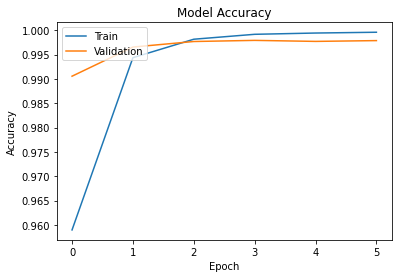

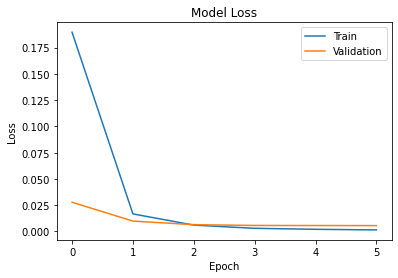

In [ ]:
# Plot accuracy
plt.plot(r.history['sparse_categorical_accuracy'])
plt.plot(r.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### Evaluate

##### preprocess function

In [ ]:
# def text_process(text):
#     ''' Pre process and convert texts to a list of words '''
#     text = str(text)
#     text = text.lower()

#     # Clean the text
#     text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
#     text = re.sub(r"what's", "what is ", text)
#     text = re.sub(r"\'s", " ", text)
#     text = re.sub(r"\'ve", " have ", text)
#     text = re.sub(r"can't", "cannot ", text)
#     text = re.sub(r"n't", " not ", text)
#     text = re.sub(r"i'm", "i am ", text)
#     text = re.sub(r"\'re", " are ", text)
#     text = re.sub(r"\'d", " would ", text)
#     text = re.sub(r"\'ll", " will ", text)
#     text = re.sub(r",", " ", text)
#     text = re.sub(r"\.", " ", text)
#     text = re.sub(r"!", " ! ", text)
#     text = re.sub(r"\/", " ", text)
#     text = re.sub(r"\^", " ^ ", text)
#     text = re.sub(r"\+", " + ", text)
#     text = re.sub(r"\-", " - ", text)
#     text = re.sub(r"\=", " = ", text)
#     text = re.sub(r"'", " ", text)
#     text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
#     text = re.sub(r":", " : ", text)
#     text = re.sub(r" e g ", " eg ", text)
#     text = re.sub(r" b g ", " bg ", text)
#     text = re.sub(r" u s ", " american ", text)
#     text = re.sub(r"\0s", "0", text)
#     text = re.sub(r" 9 11 ", "911", text)
#     text = re.sub(r"e - mail", "email", text)
#     text = re.sub(r"j k", "jk", text)
#     text = re.sub(r"\s{2,}", " ", text)

#     text = text.split()
#     text = [word for word in text if word not in stop_words]
#     text = ' '.join(text)
#     return text

##### Load and predict

In [ ]:
# def clean_stop(text):
#   text = text.split()
#   text = [word for word in text if word not in stops]
#   return ' '.join(text)

In [ ]:
num_words = len(tokenizer.word_index)
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len =30
def give_prediction(text):
  #text = clean_stop(text)
  #print(text)
  sent = []
  tagseq =[]
  text = ' '.join(word_tokenize(text))
  sentence_ids = tokenizer.texts_to_sequences([text])
  padded_ids = pad_sequences(maxlen=max_len, sequences=sentence_ids, padding="post", value=num_words)
  pred = model.predict(padded_ids)
  pred = np.argmax(pred,axis=-1)
  review_words = text.split()
  print("Interpreted as : ",tokenizer.sequences_to_texts(sentence_ids)[0])
  # text_padded = tokenizer.sequences_to_texts(sentence_ids)
  c=0
  for i,p in enumerate(pred[0,:]):
    #print(review_words[i],idx2tag[p])
    sent.append(review_words[i])
    tagseq.append(idx2tag[p])
    #print(f'{idx2word[x] : {15}} {idx2tag[y] :{15}}')
    #print("{:15}{}\t{}".format(x,y))
    c+=1
    if c == len(review_words):
      break
  return sent,tagseq
text = "The biryani and sev puri looked good but the flavor was lacking"
s,t =give_prediction(text)
print("Input: ",text)
print("Output:",t)

In [ ]:
## Print Food Entities 
## WORKS IF STOPS ARE NOT REMOVED
foods =[]
for i,(word,tag) in enumerate(zip(s,t)) :
  if i == 0:
    if tag == 'E':
      foods.append(word)
      continue
  if tag=='E':
    foods.append(word)
    if t[i-1]=='E':
      first = foods.pop(-2)
      foods[-1]=first+' '+word
print(foods)

['biryani', 'sev puri']


In [ ]:
# ### Print Food Entities 
# ### WORKS IF STOPS ARE REMOVED
# foods =[]
# for i,(word,tag) in enumerate(zip(s,t)) :
#     if tag == 'E':
#       foods.append(word)
# print(foods)

['biryani', 'sev', 'puri']
